In [1]:
import torch
from torch_geometric.datasets import MoleculeNet
import torch.nn as nn
import torch_geometric.nn as geo_nn
from torch_geometric.loader import DataLoader, ImbalancedSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
dataset = MoleculeNet(root = "../../datasets", name = "HIV")
dataset.y = dataset.y.to(torch.int64)
label = dataset.y.numpy()
train_indices, test_indices = train_test_split(
    range(len(label)), test_size=0.2, stratify=label, random_state=42
)
# train_dataset = torch.utils.data.Subset(dataset, train_indices)
train_dataset = dataset[train_indices]

test_dataset = dataset[test_indices]
train_dataset.y = train_dataset.y[train_indices]
test_dataset.y = test_dataset.y[train_indices]
len(train_dataset.y)

32901

In [5]:
sampler = ImbalancedSampler(train_dataset)
dataloader = DataLoader(train_dataset, batch_size = 64, num_workers = 8, sampler = sampler)
test_dataloader = DataLoader(test_dataset, batch_size = len(test_dataset), num_workers = 8)

8226

In [4]:
class GraphConvNet(nn.Module):
    class ConvBlock(nn.Module):
        def __init__(self, in_channel, out_channel) -> None:
            super().__init__()

            self.conv = geo_nn.GCNConv(in_channel, out_channel)
            self.relu = nn.ReLU()
        
        def forward(self, x, edge_list):
            hidden = self.conv(x, edge_list)
            return self.relu(hidden)

    def __init__(self, num_features, num_classes) -> None:
        super().__init__()
        self.num_channel = num_features
        self.conv1 = self.ConvBlock(self.num_channel, 16)
        self.conv2 = self.ConvBlock(16, 32)
        self.conv3 = self.ConvBlock(32, 64)
        self.conv4 = self.ConvBlock(64, 128)
        self.linear_layers = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )
        self.out = nn.Sigmoid()

    def forward(self, x, edge_list, batch):
        hidden = self.conv1(x, edge_list)
        hidden = self.conv2(hidden, edge_list)
        # hidden = geo_nn.max_pool(hidden, batch)
        hidden = self.conv3(hidden, edge_list)
        hidden = self.conv4(hidden, edge_list)
        hidden = geo_nn.global_mean_pool(hidden, batch)
        return self.linear_layers(hidden)

In [5]:
from tqdm import tqdm
net = GraphConvNet(dataset.num_features, 2)
net.to(device)
optimizer = torch.optim.Adam(net.parameters(), lr = 2e-4, weight_decay=1e-6)
loss_fn = nn.CrossEntropyLoss()

num_epoch = 10

for i in tqdm(range(num_epoch)):
    net.train()
    total_loss = 0
    total_correct = 0
    for batch in dataloader:
        optimizer.zero_grad()
        input_x = batch.x.to(torch.float32).to(device)
        input_batch_edge_index = batch.edge_index.to(device)
        input_batch = batch.batch.to(device)
        batch_y = batch.y.squeeze().to(torch.int64).to(device)

        output = net(input_x, input_batch_edge_index, input_batch)
        loss = loss_fn(output, batch_y)
        total_loss += loss.item()
        total_correct += (batch_y == torch.argmax(output, dim = 1)).sum()
        loss.backward()
        optimizer.step()
    # print(f'Epoch {i}. Loss: {total_loss}. Accuracy: {total_correct/len(dataset)}')

    net.eval()
    labels = []
    prediction_probabilities = []
    for batch in test_dataloader:
        input_x = batch.x.to(torch.float32).to(device)
        input_batch_edge_index = batch.edge_index.to(device)
        input_batch = batch.batch.to(device)
        batch_y = batch.y.squeeze().to(torch.int64).to(device)
        output = net(input_x, input_batch_edge_index, input_batch)
        labels.extend(list(batch_y.detach().cpu().numpy()))
        prediction_probabilities.extend(list(torch.softmax(output, dim=1)[:, 1].detach().cpu().numpy()))
    
    fpr, tpr, _ = roc_curve(labels, prediction_probabilities)
    roc_auc = auc(fpr, tpr)
    print(f'Epoch {i}. Loss: {total_loss}. Train Accuracy: {total_correct/len(dataset)}. Test ROC: {roc_auc}')

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 1/300 [00:11<57:19, 11.50s/it]

Epoch 0. Loss: 354.8263281583786. Train Accuracy: 0.4295474886894226. Test ROC: 0.6187123249569599


  1%|          | 2/300 [00:22<56:09, 11.31s/it]

Epoch 1. Loss: 348.83945977687836. Train Accuracy: 0.4592359960079193. Test ROC: 0.6378143101840488


  1%|          | 3/300 [00:33<55:37, 11.24s/it]

Epoch 2. Loss: 343.9910828471184. Train Accuracy: 0.4749677777290344. Test ROC: 0.6534665508177939


  1%|▏         | 4/300 [00:45<55:19, 11.22s/it]

Epoch 3. Loss: 341.158029794693. Train Accuracy: 0.4809006154537201. Test ROC: 0.6616357709697431


  2%|▏         | 5/300 [00:55<54:11, 11.02s/it]

Epoch 4. Loss: 336.58651500940323. Train Accuracy: 0.4903104901313782. Test ROC: 0.667370595341428


  2%|▏         | 6/300 [01:06<52:51, 10.79s/it]

Epoch 5. Loss: 333.0574880838394. Train Accuracy: 0.4988693296909332. Test ROC: 0.6720432052935901


  2%|▏         | 7/300 [01:16<52:55, 10.84s/it]

Epoch 6. Loss: 331.1425878405571. Train Accuracy: 0.5001093745231628. Test ROC: 0.6787879289892332


  3%|▎         | 8/300 [01:27<52:37, 10.81s/it]

Epoch 7. Loss: 326.68155723810196. Train Accuracy: 0.506698727607727. Test ROC: 0.6842099526853557


  3%|▎         | 9/300 [01:38<52:43, 10.87s/it]

Epoch 8. Loss: 324.1352900862694. Train Accuracy: 0.51158607006073. Test ROC: 0.6791615459633891


  3%|▎         | 10/300 [01:49<52:39, 10.90s/it]

Epoch 9. Loss: 320.07391035556793. Train Accuracy: 0.5184428691864014. Test ROC: 0.6892505121429876


  4%|▎         | 11/300 [02:00<52:40, 10.94s/it]

Epoch 10. Loss: 317.6056545972824. Train Accuracy: 0.524010956287384. Test ROC: 0.6902094042487704


  4%|▍         | 12/300 [02:12<53:12, 11.08s/it]

Epoch 11. Loss: 318.5613047480583. Train Accuracy: 0.5230140686035156. Test ROC: 0.6893710548423508


  4%|▍         | 13/300 [02:23<53:12, 11.12s/it]

Epoch 12. Loss: 316.7841205596924. Train Accuracy: 0.5260047912597656. Test ROC: 0.694134562273056


  5%|▍         | 14/300 [02:36<55:32, 11.65s/it]

Epoch 13. Loss: 314.67311853170395. Train Accuracy: 0.527269184589386. Test ROC: 0.6948617421014016


  5%|▌         | 15/300 [02:47<54:21, 11.44s/it]

Epoch 14. Loss: 314.62172615528107. Train Accuracy: 0.5260534286499023. Test ROC: 0.6977399442757041


  5%|▌         | 16/300 [02:58<53:39, 11.34s/it]

Epoch 15. Loss: 310.95458605885506. Train Accuracy: 0.5345393419265747. Test ROC: 0.7007441386384909


  6%|▌         | 17/300 [03:09<53:31, 11.35s/it]

Epoch 16. Loss: 313.0998057425022. Train Accuracy: 0.5302112698554993. Test ROC: 0.6683334110793782


  6%|▌         | 18/300 [03:21<54:07, 11.52s/it]

Epoch 17. Loss: 311.0459060072899. Train Accuracy: 0.5335910320281982. Test ROC: 0.7018680412748666


  6%|▋         | 19/300 [03:32<53:38, 11.45s/it]

Epoch 18. Loss: 309.4454534947872. Train Accuracy: 0.536970853805542. Test ROC: 0.7051333751563459


  7%|▋         | 20/300 [03:43<52:33, 11.26s/it]

Epoch 19. Loss: 307.9060893058777. Train Accuracy: 0.5390132665634155. Test ROC: 0.708547371101054


  7%|▋         | 21/300 [03:54<51:56, 11.17s/it]

Epoch 20. Loss: 307.60131844878197. Train Accuracy: 0.542174220085144. Test ROC: 0.7098700711005745


  7%|▋         | 22/300 [04:05<51:56, 11.21s/it]

Epoch 21. Loss: 307.2458277642727. Train Accuracy: 0.5426118969917297. Test ROC: 0.7103805792414574


  8%|▊         | 23/300 [04:17<51:39, 11.19s/it]

Epoch 22. Loss: 304.82654362916946. Train Accuracy: 0.5458943843841553. Test ROC: 0.704837794866407


  8%|▊         | 24/300 [04:27<51:04, 11.10s/it]

Epoch 23. Loss: 306.5211130082607. Train Accuracy: 0.5420283079147339. Test ROC: 0.7113383814494159


  8%|▊         | 25/300 [04:38<50:46, 11.08s/it]

Epoch 24. Loss: 303.37986093759537. Train Accuracy: 0.5488608479499817. Test ROC: 0.7131855402819696


  9%|▊         | 26/300 [04:50<50:39, 11.09s/it]

Epoch 25. Loss: 306.0913093984127. Train Accuracy: 0.5430738925933838. Test ROC: 0.7086892757977725


  9%|▉         | 27/300 [05:01<50:13, 11.04s/it]

Epoch 26. Loss: 303.08057340979576. Train Accuracy: 0.5486176609992981. Test ROC: 0.7112141330974504


  9%|▉         | 28/300 [05:12<50:33, 11.15s/it]

Epoch 27. Loss: 301.46288827061653. Train Accuracy: 0.5503926873207092. Test ROC: 0.7172227398025889


 10%|▉         | 29/300 [05:23<50:24, 11.16s/it]

Epoch 28. Loss: 300.9729184806347. Train Accuracy: 0.5502710938453674. Test ROC: 0.7142344579480363


 10%|█         | 30/300 [05:37<53:22, 11.86s/it]

Epoch 29. Loss: 301.60291200876236. Train Accuracy: 0.5497361421585083. Test ROC: 0.715814155854517


 10%|█         | 31/300 [05:48<51:59, 11.60s/it]

Epoch 30. Loss: 299.7537016570568. Train Accuracy: 0.5519488453865051. Test ROC: 0.7193840071880941


 11%|█         | 32/300 [05:59<50:52, 11.39s/it]

Epoch 31. Loss: 298.6978034079075. Train Accuracy: 0.5531402826309204. Test ROC: 0.718954587445336


 11%|█         | 33/300 [06:10<50:18, 11.30s/it]

Epoch 32. Loss: 299.21257531642914. Train Accuracy: 0.5518272519111633. Test ROC: 0.724629031477557


 11%|█▏        | 34/300 [06:21<49:39, 11.20s/it]

Epoch 33. Loss: 298.0254955291748. Train Accuracy: 0.5554987788200378. Test ROC: 0.7266791292849878


 12%|█▏        | 35/300 [06:32<49:24, 11.19s/it]

Epoch 34. Loss: 298.8535249233246. Train Accuracy: 0.5545748472213745. Test ROC: 0.726249491562665


 12%|█▏        | 36/300 [06:43<48:49, 11.10s/it]

Epoch 35. Loss: 296.8104483485222. Train Accuracy: 0.5546963810920715. Test ROC: 0.7281799185889921


 12%|█▏        | 37/300 [06:53<48:00, 10.95s/it]

Epoch 36. Loss: 295.41338366270065. Train Accuracy: 0.5595107674598694. Test ROC: 0.7290200118319308


 13%|█▎        | 38/300 [07:05<48:16, 11.05s/it]

Epoch 37. Loss: 296.37716126441956. Train Accuracy: 0.557273805141449. Test ROC: 0.7293134123262212


 13%|█▎        | 39/300 [07:16<48:38, 11.18s/it]

Epoch 38. Loss: 294.5403979420662. Train Accuracy: 0.5596566796302795. Test ROC: 0.7273485445286475


 13%|█▎        | 40/300 [07:28<48:56, 11.29s/it]

Epoch 39. Loss: 293.41286209225655. Train Accuracy: 0.5596566796302795. Test ROC: 0.7339245520410952


 14%|█▎        | 41/300 [07:38<47:39, 11.04s/it]

Epoch 40. Loss: 297.83927711844444. Train Accuracy: 0.5535778999328613. Test ROC: 0.7315629614354913


In [ ]:
net.eval()
labels = []
prediction_probabilities = []
for batch in test_dataloader:
    input_x = batch.x.to(torch.float32).to(device)
    input_batch_edge_index = batch.edge_index.to(device)
    input_batch = batch.batch.to(device)
    batch_y = batch.y.squeeze().to(torch.int64).to(device)
    output = net(input_x, input_batch_edge_index, input_batch)
    labels.extend(list(batch_y.detach().cpu().numpy()))
    prediction_probabilities.extend(list(torch.softmax(output, dim=1)[:, 1].detach().cpu().numpy()))
print(len(labels))

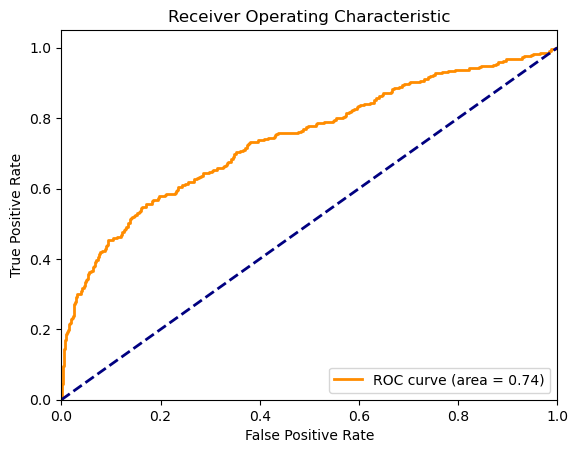

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, _ = roc_curve(labels, prediction_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('finetuned_result_gcn.png')
plt.show()
